<a href="https://colab.research.google.com/github/Tatsuro0726/Scraping/blob/master/Chapter7.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Chapter7-1: 類似画像の検出を使用
#### 簡単な形状認識 - Average Hash
- 画像を比較可能なハッシュ値で表す。ハッシュ関数:MD5, SHA256などを使う。⇒ データの値を要約したハッシュ値を得られる。
- 画像データは一般的に同一ではない(サイズとか色調, jpeg/pngなど)のため、ハッシュ関数を使えない。
- 類似度計算に使用するAverage Hashが役立つ
  1. 画像のサイズを8×8
  1. 色をグレースケールに変換
  1. 画像の各ピクセルの平均値を計算
  1. 各ピクセルの濃淡が平均より大きければ1, 平均以下なら0とする
- 上記の手順で、8×8=64bitのハッシュ値が得られる。⇒ 64ビットを比較するだけで済む。

In [ ]:
# Pythonの画像ライブラリーPillowをインストール
!pip install Pillow

In [ ]:
# avghash
from PIL import Image
import numpy as np

# 画像データをAverage Hashに変換
def average_hash(fname, size = 16):
  img = Image.open(fname)
  img = img.convert('L') # グレースケールに変換
  img = img.resize((size, size), Image.ANTIALIAS) # リサイズ　アンチエイリアス：境界線を滑らかに見せる
  pixel_data = img.getdata() # ピクセルデータを得る
  pixels = np.array(pixel_data) # numpy配列に変換
  pixels = pixels.reshape((size, size)) # 2次元配列に変換
  avg = pixels.mean() # 算術平均を計算
  diff = 1 * (pixels > avg) # 平均より大きければ1, 平均以下で0に変換
  return diff

# 2進数とみなしてハッシュ値に変換
def np2hash(n):
  bhash = []
  for nl in ahash.tolist():
    sl = [str(i) for i in nl]
    s2 = ''.join(sl)
    i = int(s2,2) # 2進数を整数に
    bhash.append('%04x' % i)
  return ''.join(bhash)

# Average Hashを表示
ahash = average_hash('./skytree.jpg')
print(ahash)
print(np2hash(ahash))

[[0 0 0 1 1 1 1 1 1 0 0 0 0 0 0 0]
 [0 0 1 1 1 1 0 1 1 1 0 1 0 0 0 0]
 [1 1 1 1 1 0 0 1 1 1 1 1 0 1 1 1]
 [1 1 1 1 1 0 0 0 1 1 1 1 0 0 1 1]
 [1 1 1 1 1 0 0 0 1 1 1 1 0 0 1 1]
 [1 1 1 1 1 0 0 0 1 1 1 1 0 0 1 1]
 [1 1 1 1 1 0 0 0 1 1 1 1 1 0 1 1]
 [1 1 1 1 0 0 0 0 1 1 1 1 1 1 1 1]
 [1 1 1 1 0 0 0 0 1 1 1 1 0 1 1 1]
 [1 1 1 1 0 0 0 0 1 1 1 1 0 1 1 1]
 [1 1 1 0 0 0 0 0 1 1 1 1 1 0 1 1]
 [1 1 1 0 0 0 0 0 0 1 1 1 1 0 1 1]
 [1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1]
 [1 1 0 0 0 0 0 0 0 1 1 1 1 1 1 1]
 [1 1 0 0 0 0 0 0 0 1 1 1 0 0 1 1]
 [1 0 0 0 0 0 0 0 0 1 1 1 1 0 1 1]]
1f803dd0f9f7f8f3f8f3f8f3f8fbf0fff0f7f0f7e0fbe07be07fc07fc073807b


In [ ]:
from PIL import Image
import numpy as np
import os, re

# ファイルパスの指定
search_dir = './drive/My Drive/Colab Folder/images/flowers'
cache_dir = './drive/My Drive/Colab Folder/images/cache_avhash'

# Cacheフォルダ作成
if not os.path.exists(cache_dir):
  os.mkdir(cache_dir)

# 画像データをAverage hashに変換
def average_hash(fname, size=16):
  fname2 = fname[len(search_dir):]
  # 画像をキャッシュしておく
  cache_file = cache_dir + '/' + fname2.replace('/', '_') + 'csv'
  if not os.path.exists(cache_file): # ハッシュを作成
    img = Image.open(fname)
    img = img.convert('L').resize((size, size), Image.ANTIALIAS)
    pixels = np.array(img.getdata()).reshape((size, size))
    avg = pixels.mean()
    px = 1 * (pixels > avg)
    np.savetxt(cache_file, px, fmt='%.0f', delimiter=',')
  else: # すでにキャッシュがあればファイルから読み込み
    px = np.loadtxt(cache_file, delimiter=',')
  return px

# 簡単にハミング距離を求める
def hamming_dist(a, b):
  aa = a.reshape(1,-1) # 1次元配列に変換
  ab = b.reshape(1,-1)
  dist = (aa != ab).sum()
  return dist

# すべてのディレクトリを列挙
def enum_all_files(path):
  for root, dirs, files in os.walk(path):
    for f in files:
      fname = os.path.join(root, f)
      if re.search(r'\.(jpg|jpeg|png)$',fname):
        yield fname

# 画像を検索
def find_image(fname, rate):
  src = average_hash(fname)
  for fname in enum_all_files(search_dir):
    dst = average_hash(fname)
    diff_r = hamming_dist(src, dst) / 256
    # print('[check]', fname)
    if diff_r < rate:
      yield (diff_r, fname)

# 検索
srcfile = search_dir + '/rose/mountain_rose_s_000071.png'
html = ''
sim = list(find_image(srcfile, 0.25))
sim = sorted(sim, key=lambda x: x[0])
for r, f in sim:
  print(r, '>', f)
  s = '<div style="float:left;"><h3>[差異:' + str(r) + '-' + \
    os.path.basename(f) + ']</h3>'+ \
    '<p><a href="' + f + '"><img src="' + f + '" width=400>'+ \
    '</a></p></div>'
  html += s

# html出力
html = """<html><body><h3>元画像</h3><p>
<img src='{0} width=400></p>{1}
</body></html>""".format(srcfile, html)
with open("./avhash-search-output.html", "w", encoding="utf-8") as f:
  f.write(html)
print('ok')

0.0 > ./drive/My Drive/Colab Folder/images/flowers/rose/mountain_rose_s_000071.png
0.2421875 > ./drive/My Drive/Colab Folder/images/flowers/tulip/tulip_s_000227.png
ok


### Chapter7-2: CNNで画像分類に挑戦しよう
CNNでカラー画像の分類に挑戦する

In [ ]:
# 画像データをPythonのデータ型に変換する
from sklearn.model_selection import train_test_split
from PIL import Image
import os, glob
import numpy as np

# 分類対象のカテゴリーを選ぶ
target_dir = './drive/My Drive/Colab Folder/images/household_furniture' 
categories = ['bed','chair','couch','table','wardrobe']
nb_classes = len(categories)

# 画像サイズの指定
image_w = 64
image_h = 64
pixles = image_w * image_h * 3

# 画像データの読み込み
X = []
Y = []
for idx, cat in enumerate(categories): # idx:繰り返しのインデックス, categoriesリストの要素
  # ラベル指定
  label = [0 for i in range(nb_classes)]
  label[idx] = 1
  # 画像
  image_dir = target_dir +'/'+ cat
  file = glob.glob(image_dir + '/*.png')
  for i, f in enumerate(file):
    img = Image.open(f)
    img = img.convert("RGB")
    img = img.resize((image_w,image_h))
    data = np.asarray(img)
    X.append(data)
    Y.append(label)
    if i % 10 == 0:
      print(i, '\n', data)
X = np.array(X)
Y = np.array(Y)

# 学習データとテストデータを分ける
X_train, X_test, y_train, y_test = \
train_test_split(X,Y)
xy = (X_train,X_test,y_train,y_test)
np.save('./drive/My Drive/Colab Folder/images/5obj.npy', xy)

print('oke,',len(Y))

0 
 [[[ 69  30  33]
  [ 70  31  34]
  [ 72  33  36]
  ...
  [234 242 240]
  [221 233 231]
  [214 228 227]]

 [[ 69  30  33]
  [ 70  31  34]
  [ 72  33  37]
  ...
  [232 242 240]
  [218 233 231]
  [211 228 226]]

 [[ 70  32  35]
  [ 71  33  36]
  [ 74  34  38]
  ...
  [229 243 239]
  [214 233 230]
  [206 228 225]]

 ...

 [[ 95  60  55]
  [ 97  62  57]
  [ 99  64  59]
  ...
  [155 133 131]
  [154 132 130]
  [153 132 130]]

 [[ 94  59  56]
  [ 95  60  58]
  [ 98  63  61]
  ...
  [152 131 130]
  [150 129 129]
  [149 128 128]]

 [[ 93  58  56]
  [ 95  60  58]
  [ 98  63  62]
  ...
  [151 130 130]
  [148 128 128]
  [147 126 127]]]
10 
 [[[254 244 215]
  [252 242 219]
  [248 239 224]
  ...
  [210 200 185]
  [205 196 179]
  [203 195 176]]

 [[254 247 224]
  [252 245 226]
  [248 242 231]
  ...
  [213 208 197]
  [208 204 191]
  [206 202 188]]

 [[254 253 241]
  [252 252 243]
  [247 250 246]
  ...
  [220 226 223]
  [215 221 216]
  [212 218 214]]

 ...

 [[101  91  85]
  [ 98  90  87]
  [ 91  88 

In [ ]:
# CNNを実践してみよう
from keras.models import Sequential
from keras.layers.convolutional import Conv2D
from keras.layers.pooling import MaxPool2D
from keras.layers import  Activation, Dropout, Flatten, Dense
import numpy as np

# カテゴリーの指定
categories = ['bed','chair','couch','table','wardrobe']
nb_classes = len(categories)
# 画像サイズのして
image_w = 64
image_h = 64

# データをロード
X_train, X_test, y_train, y_test = np.load('./drive/My Drive/Colab Folder/images/5obj.npy',allow_pickle=True)
# データを正規化する
X_train = X_train.astype('float') / 256
X_test = X_test.astype('float') / 256
print('X_train shape:', X_train.shape)

# モデル構築
in_shape = X_train.shape[1:]
model = Sequential()
model.add(Conv2D(32, 3, input_shape=in_shape))
model.add(Activation('relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3,3)))
model.add(Activation('relu'))
model.add(Conv2D(64, (3,3)))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dropout(0.25))
model.add(Dense(nb_classes))
model.add(Activation('softmax'))

model.compile(loss='binary_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

# モデルを訓練する
model.fit(X_train, y_train, batch_size=32, epochs=50)

# モデルを評価する
score = model.evaluate(X_test, y_test)
print('loss=', score[0])
print('accuracy=', score[1])


X_train shape: (375, 64, 64, 3)
Epoch 1/50
12/12 [==============================] - 4s 353ms/step - loss: 0.7356 - accuracy: 0.2720
Epoch 2/50
12/12 [==============================] - 4s 351ms/step - loss: 0.4847 - accuracy: 0.3280
Epoch 3/50
12/12 [==============================] - 4s 352ms/step - loss: 0.4918 - accuracy: 0.2880
Epoch 4/50
12/12 [==============================] - 4s 346ms/step - loss: 0.4501 - accuracy: 0.3947
Epoch 5/50
12/12 [==============================] - 4s 349ms/step - loss: 0.4377 - accuracy: 0.4400
Epoch 6/50
12/12 [==============================] - 4s 349ms/step - loss: 0.4067 - accuracy: 0.4880
Epoch 7/50
12/12 [==============================] - 4s 354ms/step - loss: 0.3780 - accuracy: 0.5360
Epoch 8/50
12/12 [==============================] - 4s 350ms/step - loss: 0.3685 - accuracy: 0.5467
Epoch 9/50
12/12 [==============================] - 4s 347ms/step - loss: 0.3080 - accuracy: 0.6347
Epoch 10/50
12/12 [==============================] - 4s 348ms/step -

In [ ]:
from PIL import Image
pre = model.predict(X_test)

for i, v in enumerate(pre):
  pre_ans = v.argmax() # 予測したラベル
  ans = y_test[i].argmax()
  dat = X_test[i] # 画像データ
  if ans == pre_ans: continue
  # 予測を間違えたものについて、何と何を間違えたのか出力
  print("[NG]", categories[pre_ans], "!=", categories[ans])
  print(v)
  # 画像を出力
  fname = './drive/My Drive/Colab Folder/images/error/' + str(i) + "-" + categories[pre_ans] + \
    "-ne-" + categories[ans] + ".PNG"
  dat *= 256
  img = Image.fromarray(np.uint8(dat))
  img.save(fname)

[NG] chair != table
[0. 1. 0. 0. 0.]
[NG] wardrobe != bed
[1.6384888e-02 1.5441352e-04 7.8651071e-02 1.8908903e-03 9.0291876e-01]
[NG] wardrobe != bed
[1.9139630e-01 1.0787819e-04 9.1980984e-03 1.2428723e-03 7.9805481e-01]
[NG] couch != bed
[3.9907976e-05 3.2804212e-05 9.9849474e-01 3.0804364e-05 1.4016768e-03]
[NG] couch != bed
[5.2448304e-04 7.1106642e-04 9.9483138e-01 3.9331019e-03 3.6483299e-12]
[NG] chair != table
[7.1851167e-12 9.9997187e-01 5.4305463e-08 2.8165608e-05 1.8864003e-12]
[NG] wardrobe != table
[7.0604047e-09 1.1430849e-12 1.3504871e-08 6.6206262e-06 9.9999332e-01]
[NG] couch != table
[1.5918339e-04 5.3491926e-06 9.9553549e-01 6.9013884e-04 3.6098999e-03]
[NG] chair != couch
[6.5146191e-17 9.9999952e-01 4.5355895e-07 2.9177168e-13 3.3774456e-17]
[NG] chair != bed
[1.9454696e-03 9.8911953e-01 8.0382908e-03 5.2452291e-04 3.7227338e-04]
[NG] chair != couch
[4.1695393e-14 1.0000000e+00 9.8744862e-13 1.8114227e-11 4.7088342e-19]
[NG] couch != wardrobe
[1.5005540e-03 3.2916

In [ ]:
import os

# 学習済みモデルを保存
hdf5_file = "./drive/My drive/Colab Folder/images/5obj-model.hdf5"
if os.path.exists(hdf5_file):
  # 既存のファイルを読み込む
  model.load_weights(hdf5_file)
else:
  # モデルを学習させてファイルに保存しておく
  model.fit(X_train, y_train, batch_size=32, epochs=50)
  model.save_weights(hdf5_file)

Epoch 1/50
12/12 [==============================] - 4s 354ms/step - loss: 0.0021 - accuracy: 1.0000
Epoch 2/50
12/12 [==============================] - 4s 345ms/step - loss: 7.9549e-04 - accuracy: 1.0000
Epoch 3/50
12/12 [==============================] - 4s 347ms/step - loss: 3.9181e-04 - accuracy: 1.0000
Epoch 4/50
12/12 [==============================] - 4s 348ms/step - loss: 0.0044 - accuracy: 0.9947
Epoch 5/50
12/12 [==============================] - 4s 351ms/step - loss: 0.3073 - accuracy: 0.8720
Epoch 6/50
12/12 [==============================] - 4s 345ms/step - loss: 0.0134 - accuracy: 0.9920
Epoch 7/50
12/12 [==============================] - 4s 356ms/step - loss: 4.9301e-04 - accuracy: 1.0000
Epoch 8/50
12/12 [==============================] - 4s 359ms/step - loss: 8.9283e-05 - accuracy: 1.0000
Epoch 9/50
12/12 [==============================] - 4s 345ms/step - loss: 7.6381e-05 - accuracy: 1.0000
Epoch 10/50
12/12 [==============================] - 4s 348ms/step - loss: 5.581

OSError: ignored

In [ ]:
hdf5_file = "./drive/My Drive/Colab Folder/images/5obj-model.hdf5"
model.fit(X_train, y_train, batch_size=32, epochs=50)
model.save_weights(hdf5_file)

Epoch 1/50
12/12 [==============================] - 4s 355ms/step - loss: 8.9569e-05 - accuracy: 1.0000
Epoch 2/50
12/12 [==============================] - 4s 358ms/step - loss: 6.2335e-04 - accuracy: 1.0000
Epoch 3/50
12/12 [==============================] - 4s 347ms/step - loss: 1.9820e-04 - accuracy: 1.0000
Epoch 4/50
12/12 [==============================] - 4s 349ms/step - loss: 7.5876e-05 - accuracy: 1.0000
Epoch 5/50
12/12 [==============================] - 4s 350ms/step - loss: 1.0171e-05 - accuracy: 1.0000
Epoch 6/50
12/12 [==============================] - 4s 349ms/step - loss: 1.7606e-06 - accuracy: 1.0000
Epoch 7/50
12/12 [==============================] - 4s 349ms/step - loss: 7.0859e-05 - accuracy: 1.0000
Epoch 8/50
12/12 [==============================] - 4s 351ms/step - loss: 0.1015 - accuracy: 0.9680
Epoch 9/50
12/12 [==============================] - 4s 358ms/step - loss: 0.0021 - accuracy: 0.9973
Epoch 10/50
12/12 [==============================] - 4s 359ms/step - los

OSError: ignored

In [ ]:
hdf5_file = "./drive/My Drive/Colab Folder/images/5obj-model.hdf5"
model.save_weights(hdf5_file)

### Chapter7-3: 牛丼屋のメニューを画像判定しよう

200


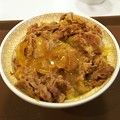

In [46]:
# スクレイピングを行う
# フォト蔵
# API仕様：http://photozou.jp/basic/api_method_search_public

import requests, json

url = 'https://api.photozou.jp/rest/search_public.json'
params = {
    'keyword': '牛丼',
    'offset': 0,
    'limit':5
}

res = requests.get(url, params=params)

print(res.status_code)

json_file = open('./drive/My Drive/Colab Folder/image/test.json', 'w')
json.dump(res.json(), json_file, indent=4, separators=(',', ':'))
test = json.load(open('./drive/My Drive/Colab Folder/image/test.json', 'r'))
image_url = test['info']['photo'][1]['thumbnail_image_url']

res2 = requests.get(image_url)
with open('./drive/My Drive/Colab Folder/image/test.jpg', 'wb') as fp:
  fp.write(res2.content)

from IPython.display import Image
Image("./drive/My Drive/Colab Folder/image/test.jpg")
# with open('./drive/My Drive/Colab Folder/image/test.png', 'wb') as fp:
#   fp.write(bindata)
# fp.close()
# print(res.json())
# for i in res.json():
#   print(i)
# res.content

In [58]:
## サムネイル画像をダウンロードするプログラム

import sys, os, re, time
import requests
import urllib.parse as parse
import json

# APIのURL指定
PHOTOZOU = "https://api.photozou.jp/rest/search_public.json"
CACHE_DIR = "./drive/My Drive/Colab Folder/image/cache"

# フォト蔵のAPIを利用して画像を検索する
def search_photo(keyword, offset=0, limit=100):
  """ 画像を検索して、json形式で返す
  　　keyword: 検索したい文字列
      offset :
      limit  : 検索結果の件数"""
  # APIクエリの組み立て
  params = {
      'keyword': keyword,
      'offset': offset,
      'limit': limit
  }
  # キャッシュ用のディレクトリーを作成
  if not os.path.exists(CACHE_DIR):
    os.makedirs(CACHE_DIR)
  # リクエストを投げる
  res = requests.get(PHOTOZOU, params)
  # キャッシュファイル名
  cache = CACHE_DIR + '/' + keyword + '_' + str(offset) + '_' + str(limit) + '.json'
  # キャッシュファイルが存在する場合
  if os.path.exists(cache):
    return json.load(open(cache, 'r', encoding='utf-8'))
  # 存在しない場合
  print("[API]" + res.url)
  time.sleep(1) # 利用マナーとして1秒スリープ
  json.dump(res.json(), open(cache, 'w', encoding='utf-8'), indent=4, separators=(',', ':'))
  return json.load(open(cache, 'r',encoding='utf-8'))

# 画像をダウンロードする
def download_thumb(info, save_dir):
  """フォト蔵のjsonデータから画像をダウンロードする
     info     : jsonデータ
     save_dir : 保存先ディレクトリ"""
  if not os.path .exists(save_dir): os.makedirs(save_dir)
  if info is None: return
  if not 'photo' in info['info']:
    print('[ERROR] broken info')
    return
  photolist = info['info']['photo']
  for photo in photolist:
    title = photo['photo_title']
    photo_id = photo['photo_id']
    url = photo['thumbnail_image_url']
    path = save_dir + '/' + str(photo_id) + '_thumb.jpg'
    if os.path.exists(path): continue
    try:
      print('[download]', title, photo_id, url)
      image = requests.get(url)
      with open(path, 'wb') as fp:
        fp.write(image.content)
      time.sleep(1) # マナーとして1秒スリープ
    except Exception as e:
      print('[ERROR] failed to download url=', url)

# 検索結果を全部取得する
def download_all(keyword, save_dir, maxphoto=300):
  # 設定値
  offset = 0
  limit = 50
  while True:
    # APIを呼び出す
    info = search_photo(keyword, offset=offset, limit=limit)
    if info is None:
      print('[ERORR] no result'); return
    if (not 'info' in info) or (not 'photo_num' in info['info']):
      print('[ERORR] broken data'); return
    photo_num = info['info']['photo_num']
    if photo_num == 0:
      print('photo_num = 0, offset=', offset)
      return
    # 写真情報が含まれていればダウンロード
    print('***download offset=', offset)
    download_thumb(info, save_dir)
    offset += limit
    if offset >= maxphoto: break

In [60]:
download_all('牛丼', './drive/My Drive/Colab Folder/image/gyudon', maxphoto=50)

***download offset= 0
[download] 今日のお昼はすき家の牛丼?? 264829858 http://art5.photozou.jp/pub/167/1604167/photo/264829858_thumbnail.jpg
[download] 今日のお昼はすき家の牛丼?? 264829735 http://art5.photozou.jp/pub/167/1604167/photo/264829735_thumbnail.jpg
[download] PC153787 264777347 http://art5.photozou.jp/pub/856/483856/photo/264777347_thumbnail.jpg
[download] コメ「力也の生理」(クリームチーズアラビアータ牛丼メガ) 264744017 http://art5.photozou.jp/pub/869/3204869/photo/264744017_thumbnail.png
[download] すき家でクリームチーズアラビアータ牛丼メガ980円＋とん汁190円＆さば230円＆情熱の大辛ソース30円＆キムチ130円　計1,560円 264743895 http://art5.photozou.jp/pub/869/3204869/photo/264743895_thumbnail.png
[download] 白髪ネギ牛丼＋健康セット（すき家） 264674552 http://art5.photozou.jp/pub/672/145672/photo/264674552_thumbnail.jpg
[download] ねぎ多い 牛丼です 264625173 http://art5.photozou.jp/pub/86/2574086/photo/264625173_thumbnail.jpg
[download] ねぎだく牛丼 サラダ 味噌汁セット 264625172 http://art5.photozou.jp/pub/86/2574086/photo/264625172_thumbnail.jpg
[download] 淡路島牛丼 264580749 http://kura1.photozou.jp/pub/555/190555/phot